In [1]:
#imports
import numpy as np
from scipy import optimize
import LinConGauss as lcg

%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gurobipy as gp
from gurobipy import GRB
from tqdm import trange, tqdm

import torch
from torch import nn

from pathlib import Path
import pathlib

#initialization (new preferred way to do it via Generator)
rng=np.random.default_rng(73)

In [2]:
def find_max_dist_interpolator(dataset, env):
    """
    Given the dataset, calculates maximum distance interpolator 
    It assumes that the real signal is (1,0,...,0)
    Args:
        dataset (tuple): Tuple containing X and y. X is the np.array containing 
            x values from the halfspace learning model. y is the list
            of corresponding y values. 
        env: Gurobi optimizer environment object.

    Returns:
        bool: Worst case interpolator.
    """
    
    X,y=dataset
    N,d=X.shape

    with gp.Model(env=env) as m:
        w=[m.addVar(name='w'+str(i), lb=-float('inf')) for i in range(d)]


        # Set objective: x
        obj = 1.0*w[0]
        m.setObjective(obj, GRB.MINIMIZE)

        for i in range(N):
            m.addConstr(sum((w[j] * X[i][j] * y[i] for j in range(d))) >= 0, '%d lin. constraint' % i)

        m.addConstr(sum(w[i]**2 for i in range(d)) <= 1, 'w norm constraint')

        m.optimize()

        res_w=np.zeros(d)
        for i, v in enumerate(m.getVars()):
            res_w[i]=v.x

        return res_w

                    
def uniform_sample_from_hypersphere(d, r=1):
    """
    Samples an element uniformly random from the
    d-dimensional hypersphere of radius r.
    Args:
        d (int): Dimension of the hypersphere. 
        r (float): Radius of the hypersphere.

    Returns:
        np.array: Sample from the d-dimensional hypersphere of radius r.
    """
    
    if d<=0:
        raise ValueError('Dimension of sphere has to be positive integer')
    if r<=0:
        raise ValueError('Sphere radius has to be positive')

    tmp=rng.multivariate_normal(np.zeros(d), np.eye(d))
    tmp/=np.linalg.norm(tmp)
    
    return tmp*r
        
    
def create_canonic_alpha(d, num_nonzero_el=1):
    """
    Creates canonic signal vector of dimension d with 
    number of nonzero element equal to num_nonzero_el.
    Args:
        d (int): Dimension of signal vector.
        num_nonzero_el (float): Number of nonzero elements of the signal vector

    Returns:
        np.array: Canonic signal vector.
    """
    
    if d<=0:
        raise ValueError('Dimension of alpha has to be positive integer')
    if num_nonzero_el<=0 or num_nonzero_el>d:
        raise ValueError('Alpha has to have number of nonzero elements in range [1, {}]'.format(d))
        
        
    alpha=np.zeros(d)
    for j in range(num_nonzero_el):
        alpha[j]=(1/num_nonzero_el)**(1/2)

    return alpha

    
#dataset generating function
def generate_halfspace_dataset(n, d, alpha=None, noise=True, noise_sigma=1):
    """
    Generates halfspace learning model dataset of n samples.
    Args:
        n (int): Number of samples.
        d (int): Dimension of the halfspace learning model.
        alpha (np.array): Signal vector.
        noise (bool): Boolean value indicating whether we want 
            to include noise into the model.
        noise_sigma (float): Root value of the noise variation.

    Returns:
        tuple: Pair (X,y) where X is np.array of x values, while y is a list holding
            the corresponding y values.
    """
    
    if d<=0:
        raise ValueError('Dimension of multivariate normal distribution has to be positive integer')
    if n<=0:
        raise ValueError('Number of datapoints in dataset has to be positive integer')
    if alpha is not None and len(alpha)!=d:
        raise ValueError('Incompatible dimension between given alpha vector and d')
    
    if alpha is None:#generate alpha vector
        alpha=uniform_sample_from_hypersphere(d)
        return_alpha=True
    else:
        return_alpha=False
    
    mean_vec=np.zeros(d)
    cov_matr=np.eye(d)   
    
    X=rng.multivariate_normal(mean_vec, cov_matr, size=n)
    
    if noise:
        epsilon=rng.normal(0, noise_sigma, size=n)
    else:
        epsilon=[0]*n
        
    Y=np.sign(np.matmul(X,alpha)+epsilon)
    
    if return_alpha:
        return (X,Y),alpha
    
    return (X,Y)


def create_signal_vector(d, num_nonzero_el=1):
    """
    Same as create_canonic_alpha function.
    Args:
        d (int): Dimension of signal vector.
        num_nonzero_el (float): Number of nonzero elements of the signal vector

    Returns:
        np.array: Canonic signal vector.
    """
    
    sign_vec=np.zeros(d)

    for j in range(num_nonzero_el):
        sign_vec[j]=(1/num_nonzero_el)**(1/2)
        
    return sign_vec

In [3]:
def naive_sample_from_interpolator_set(dataset, n=1):
    """
    Funcion samples n interpolators from the interpolator set naively.
    This means that we sample from the general set of hypothesis and 
    if the element that we sampled does not belong to interpolator set,
    we discard it. This is done until n number of interpolators are sampled.
    Args:
        dataset (tuple): Tuple (X,y), where X is np.array corresponding to x values
            from the halfspace learning model, and y is list corresponding y values.
        n (int): Number of interpolators to sample.

    Returns:
        np.array: Interpolators sampled.
    """
    
    if dataset is None:
        raise ValueError('Dataset must not be empty')
    if n<=0:
        raise ValueError('Number of samples to be drawn has to be greater than 0')
    
    X,Y=dataset
    d,N=X.shape[1],X.shape[0]
    
    sample=[]
    while True:
        #sample w
        w=uniform_sample_from_hypersphere(d)
        accept=True
        for j in range(N):
            x_j,y_j=X[j,:],Y[j]
            if np.sign(np.matmul(w,x_j))!=y_j:
                accept=False
                break

        if accept:
            sample.append(w)

        if len(sample)>=n:
            break
                
    return np.array(sample)

def sample_from_interpolator_set(dataset, n=1):
    """
    Funcion samples n interpolators from the interpolator set 
    using the LIN-ESS MCMC algorithm from https://github.com/alpiges/LinConGauss.
    Args:
        dataset (tuple): Tuple (X,y), where X is np.array corresponding to x values
            from the halfspace learning model, and y is list corresponding y values.
        n (int): Number of interpolators to sample.

    Returns:
        np.array: Interpolators sampled.
    """
    
    if dataset is None:
        raise ValueError('Dataset must not be empty')
    if n<=0:
        raise ValueError('Number of samples to be drawn has to be greater than 0')
        
    X,Y=dataset
    
    N,d=X.shape[0],X.shape[1]
    
    Y_broadcasted=np.repeat(Y.reshape((N, 1)), d, axis=1)
    
    #linear constraints Aw+b>=0 which has to hold for w to be interpolator
    A=X*Y_broadcasted
    b=np.zeros((N, 1))
    lin_con=lcg.LinearConstraints(A=A,b=b)
    
    subset_sim = lcg.multilevel_splitting.SubsetSimulation(linear_constraints=lin_con,
                                                      n_samples=16,
                                                      domain_fraction=0.5,
                                                      n_skip=10)
    subset_sim.run(verbose=False)
    
    init_sample=subset_sim.tracker.x_inits()[:,-1]
    init_sample=init_sample.reshape((d,1))
    
    # Elliptical slice sampler, set n_iterations to n-1 because algorithm also returns initial point that fulfills criteria, but does not count it
    sampler = lcg.sampling.EllipticalSliceSampler(n_iterations=n-1,
                                                  linear_constraints=lin_con,
                                                  n_skip=10,
                                                  x_init=init_sample)
    sampler.run()

    unnormalized_samples=sampler.loop_state.X.T#need to normalize them
    l2_norm=np.linalg.norm(unnormalized_samples, axis=1)
    return unnormalized_samples/l2_norm.reshape((l2_norm.shape[0],1))

In [4]:
def check_interpolator(dataset, w):
    """
    Checks whether w is an interpolator for the given dataset.
    Args:
        dataset (tuple): Tuple (X,y), where X is np.array corresponding to x values
            from the halfspace learning model, and y is list corresponding y values.
        w (np.array): Vector which is checked for being the interpolator. 

    Returns:
        bool: Value corresponding to the result of the test whether w is an interpolator.
    """
    
    X,Y=dataset
    
    N=X.shape[0]
    
    interpolator=True
    for j in range(N):
        x_j,y_j=X[j,:],Y[j]
        if np.sign(np.matmul(w,x_j))!=y_j:
            interpolator=False
            break

    if interpolator:
        return True

    return False

In [5]:
def estimate_diff_norm(sample, alpha):
    """
    Function calculates the mean value of the L2 norms
    norms of the difference between the samples and vector alpha.
    Args:
        sample (np.array): Sample.
        alpha (np.array): Vector alpha.

    Returns:
        float: Calculated value.
    """
    if sample is None:
        raise ValueError('Sample provided can not be of value None')
    if alpha is None:
         raise ValueError('Base vector provided can not be of value None')
    
    N=sample.shape[0]
    
    diff=sample-alpha
    diff_norm=np.linalg.norm(diff, axis=1)
        
    return np.sum(diff_norm)/N

In [6]:
def L1_norm_minimization_estimate(dataset):
    """
    Not important atm.
    """
    #min <c,x> st. Ax<=b->derivation made in report
    X,Y=dataset
    N,d=X.shape[0],X.shape[1]
    
    c=np.concatenate((np.zeros(d), np.ones(d)))
    
    Y_broadcasted=np.repeat(Y.reshape((N, 1)), d, axis=1)
    A1=-np.concatenate((X*Y_broadcasted, np.zeros((N,d))), axis=1)
    b1=-np.ones(N)
    
    A2=-np.concatenate((np.eye(d), np.eye(d)), axis=1)
    b2=np.zeros(d)
    
    A3=np.concatenate((np.eye(d), -np.eye(d)), axis=1)
    b3=np.zeros(d)
    
    A=np.concatenate((A1,A2,A3))
    b=np.concatenate((b1,b2,b3))
        
    return optimize.linprog(c=c,A_ub=A,b_ub=b)

def plot_w_sample_interpolator(sample, alpha, L1_min_sol, ax):
    """
    Not important atm.
    """
    N=sample.shape[0]
            
    diff=sample-alpha
    diff_norm=np.linalg.norm(diff, axis=1)
    
    L1_min_diff_norm=np.linalg.norm(L1_min_sol-alpha)
    
    x_vals=np.arange(N)

    ax.plot(x_vals, diff_norm, 'x')
    ax.axhline(y=L1_min_diff_norm, color='red')

In [22]:
d,N=50,49

#crete alpha vector
alpha=np.zeros(d)
num_nonzero_el=d
for j in range(num_nonzero_el):
    alpha[j]=(1/num_nonzero_el)**(1/2)

dataset=generate_halfspace_dataset(N, len(alpha), alpha=alpha)

w_sample_interpolator=sample_from_interpolator_set(dataset, n=1000)

expected_diff_in_F_inter=estimate_diff_norm(w_sample_interpolator, alpha)
print('Expected L2 norm of difference between alpha and interpolator vector: {}'.format(expected_diff_in_F_inter))

L1_sol=L1_norm_minimization_estimate(dataset)

w_L1_sol=L1_sol.x[:d]
w_L1_sol/=np.linalg.norm(w_L1_sol)#normalize L1 norm minimization solution

print('L1 minimization solution: {}'.format(w_L1_sol))

L1_diff_norm=np.linalg.norm(w_L1_sol-alpha)
print('L2 norm of difference between alpha and L1 norm minimization solution: {}'.format(L1_diff_norm))

#plot_w_sample_interpolator(w_sample_interpolator, alpha, w_L1_sol)

print(check_interpolator(dataset, w_L1_sol))

Expected L2 norm of difference between alpha and interpolator vector: 1.1691989138857455
L1 minimization solution: [4.99514151e-02 2.73861431e-11 1.24885399e-10 4.15338034e-01
 1.49867320e-01 1.53160784e-01 5.85015338e-11 5.57663381e-02
 2.47852177e-12 4.69802865e-11 3.30036331e-01 1.26278739e-01
 1.37451445e-01 1.47277958e-11 2.25812627e-01 1.96155201e-11
 1.72581121e-01 2.36693357e-10 2.21302724e-01 8.48171371e-11
 1.64409412e-02 2.40142190e-01 1.41657794e-11 7.75107985e-12
 2.12380921e-11 1.51430874e-11 1.83750360e-11 3.64263672e-01
 3.07477140e-02 1.56049449e-12 5.18911946e-11 1.50660028e-01
 1.13008652e-01 1.97145505e-11 3.78627081e-11 2.74524824e-11
 2.03890284e-11 3.57563954e-01 5.15788053e-02 9.58349463e-02
 1.77103269e-01 1.79933388e-01 5.97415260e-02 1.79644505e-01
 3.24902260e-11 1.13062895e-11 2.23545222e-11 2.29470472e-11
 1.90095418e-01 2.28248986e-11]
L2 norm of difference between alpha and L1 norm minimization solution: 0.8941638611139983
True


(1000, 5)
(1000, 5)
(1000, 5)
(1000, 5)
(1000, 5)
(1000, 5)
(1000, 5)
(1000, 5)
(1000, 5)
(1000, 5)
(1000, 5)


KeyboardInterrupt: 

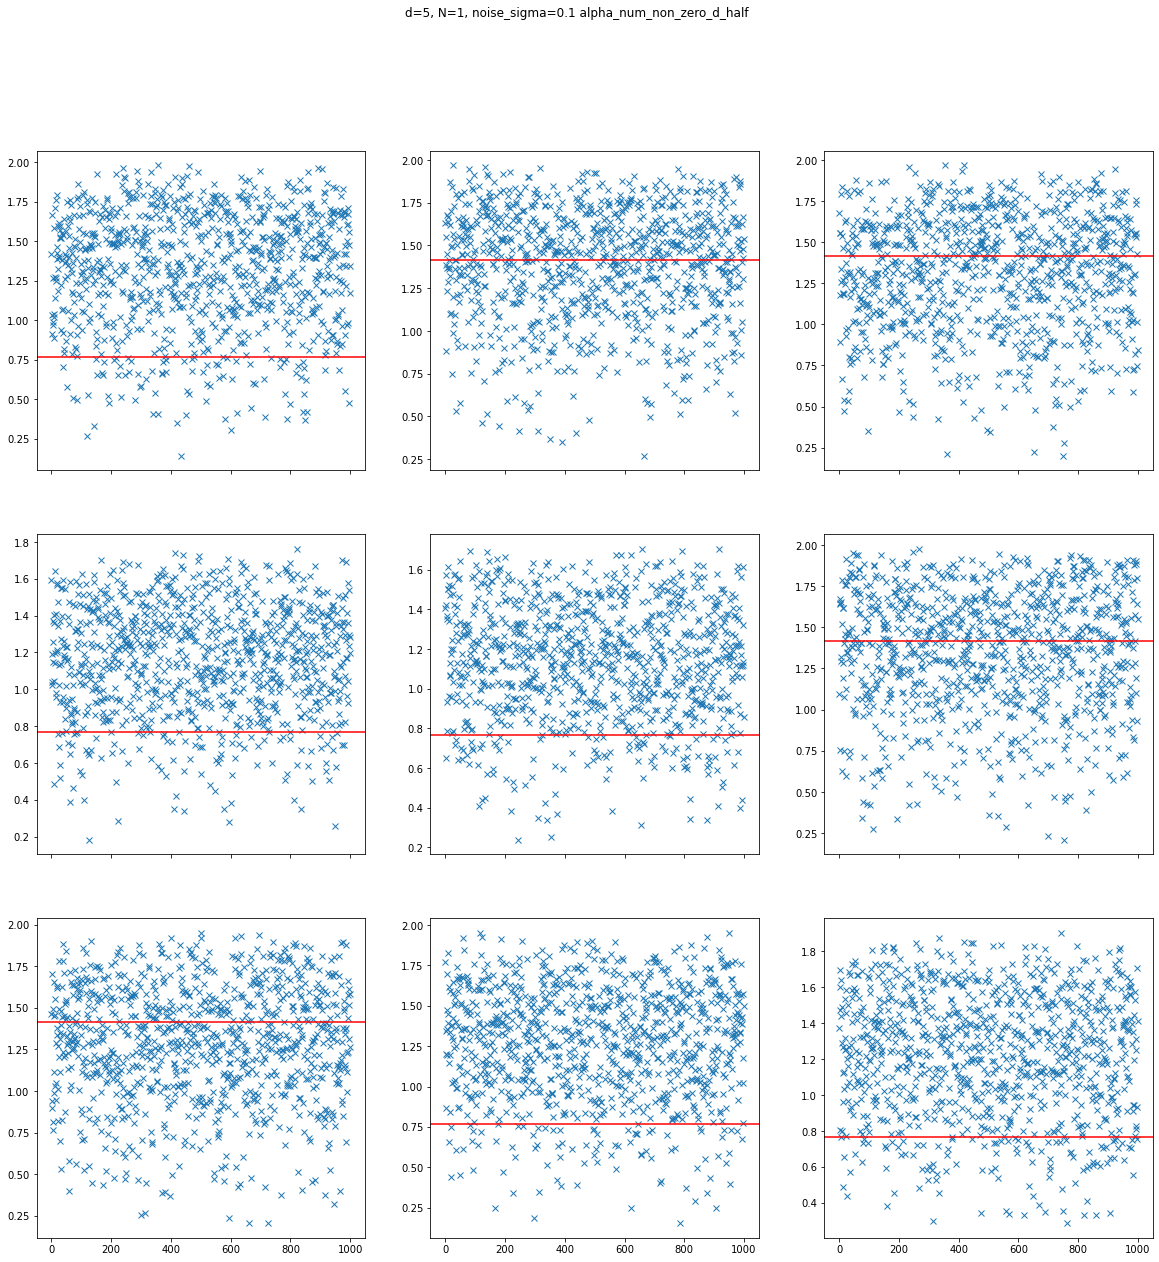

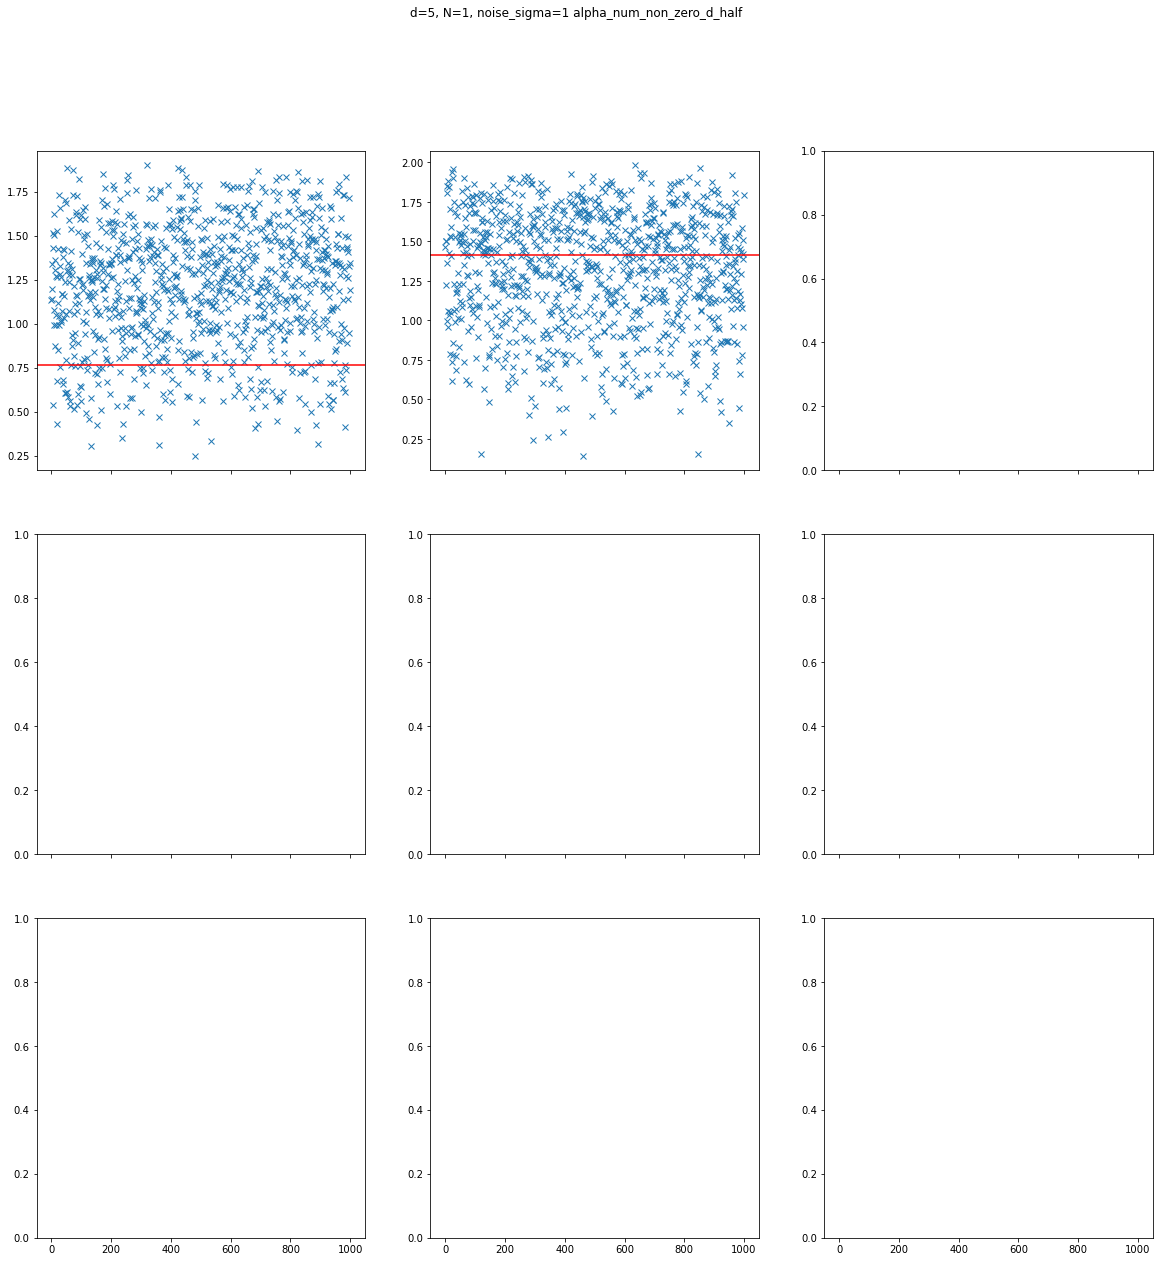

In [33]:
d_N_sigma_tuples=[]
for d in (5,10,75):
    for N in (1, d//2, d-1):
        for noise_sigma in (0.1,1,10):
            d_N_sigma_tuples.append((d,N,noise_sigma))
 

n_iter=9
for d,N,noise_sigma in d_N_sigma_tuples:
    
    #crete alpha vector
    alpha=np.zeros(d)
    num_nonzero_el=d//2
    for j in range(num_nonzero_el):
        alpha[j]=(1/num_nonzero_el)**(1/2)

    n_iter_root=int(n_iter**(1/2))
    
    fig,axs=plt.subplots(n_iter_root,n_iter_root, figsize=(20,20), sharex=True, sharey=False)
    title='d={}, N={}, noise_sigma={} alpha_num_non_zero_d_half'.format(d,N,noise_sigma)
    fig.suptitle(title)    
    axs=axs.flatten()
    
    inter_avg,L1_min_sol_avg=0,0
    for i in range(n_iter):
        dataset=generate_halfspace_dataset(N, len(alpha), alpha=alpha, noise_sigma=noise_sigma)

        w_sample_interpolator=sample_from_interpolator_set(dataset, n=1000)
        expected_diff_in_F_inter=estimate_diff_norm(w_sample_interpolator, alpha)

        L1_sol=L1_norm_minimization_estimate(dataset)

        w_L1_sol=L1_sol.x[:d]
        w_L1_sol/=np.linalg.norm(w_L1_sol)#normalize L1 norm minimization solution

        L1_diff_norm=np.linalg.norm(w_L1_sol-alpha)

        inter_avg+=expected_diff_in_F_inter
        L1_min_sol_avg+=L1_diff_norm

        plot_w_sample_interpolator(w_sample_interpolator, alpha, w_L1_sol, axs[i])

    plt.savefig(title+'.png')

    
#for higher dimensions position of L1 minimization is much more fixed inside of random samples
#as we add more samples (increase N), L1 minimization solution tends to move lower and lower when compared to other randomly chosen interpolators
#for sparse alpha, L1 minimization is in middle of random interpolators, but when also d is low, it sometime happens that it is below random interpolators
#conjencture, as dimension increases probability of L1 minimizer being better than random minimizer gets lower (for sparse alpha)
#conjecture, as d->N L1 minimizer gets more and more often below random interpolators
#but for low dimensions this happens less often than in high dimensions
#for constant N,d L1_norm minimizer performs better and better when compared to random interpolators as we reduce the noise (only for sparse alpha)
#for non-sparse alpha thing is quiet the oposite (it still performs better, but not as much)

In [7]:
import os, uuid


def random_interp_vs_L1_interp_plot(d, N, alpha_num_nonzero=1, noise=True, noise_sigma=1, target_folder=None):
    """
    Not important atm.
    """
    if d<=0:
        raise ValueError('Dimension has to be positive integer')
    if N<=0:
        raise ValueError('Size of training dataset has to be positive integer')
    if alpha_num_nonzero<=0 or alpha_num_nonzero>d:
        raise ValueError('Number of nonzero elements of alpha has to be in range [1, {}]'.format(d))
    if noise and noise_sigma<=0:
        raise ValueError('Noise sigma has to be positive')
        
        
    if target_folder is None:
        cwd = os.getcwd()
        target_folder=cwd+'/'+str(uuid.uuid4())
        
        os.mkdir(target_folder)
    else:
        try:
            os.mkdir(target_folder)
        except FileExistsError as ex:
            print(ex)
            return
    
    #create alpha
    alpha=create_canonic_alpha(d, num_nonzero_el=alpha_num_nonzero)
    
    #set noise sigma to right value
    noise_sigma=0 if not noise else noise_sigma
    
    fig,axs=plt.subplots(3, 3, figsize=(20,20), sharex=True, sharey=False)
    title='d={}, N={}, noise_sigma={} alpha_num_non_zero_{}'.format(d,N,noise_sigma, alpha_num_nonzero)
    fig.suptitle(title)    
    axs=axs.flatten()
    
    for i in range(9):
        dataset=generate_halfspace_dataset(N, len(alpha), alpha=alpha, noise=noise, noise_sigma=noise_sigma)

        w_sample_interpolator=sample_from_interpolator_set(dataset, n=2000)
        expected_diff_in_F_inter=estimate_diff_norm(w_sample_interpolator, alpha)

        L1_sol=L1_norm_minimization_estimate(dataset)

        w_L1_sol=L1_sol.x[:d]
        w_L1_sol/=np.linalg.norm(w_L1_sol)#normalize L1 norm minimization solution

        L1_diff_norm=np.linalg.norm(w_L1_sol-alpha)


        plot_w_sample_interpolator(w_sample_interpolator, alpha, w_L1_sol, axs[i])

    plt.savefig(target_folder+'/'+title+'.png')
    
        
random_interp_vs_L1_interp_plot(d=100, N=99, alpha_num_nonzero=50, noise=False, noise_sigma=1, target_folder='./img_noise8')

[Errno 17] File exists: './img_noise8'


d: 400


KeyboardInterrupt: 

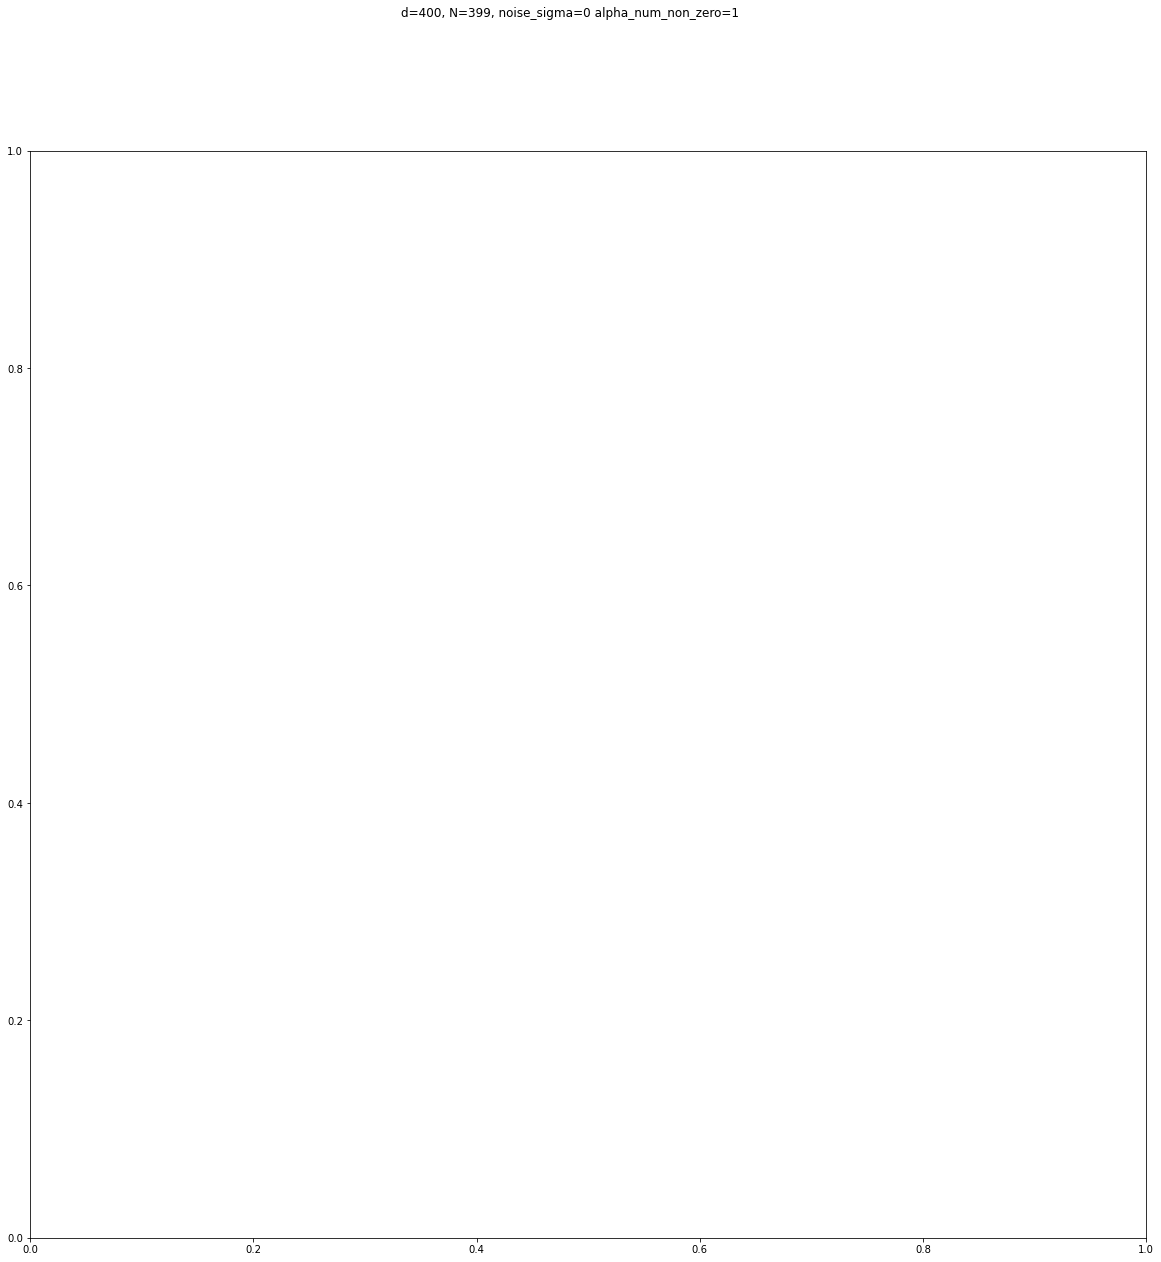

In [32]:
#RUN THIS
#crete alpha vector
def calc_sample_alpha_diff_norm(sample, alpha):
    """
    Calculates norm of difference between the samples and vector alpha.
    Args:
        sample (np.array): Samples.
        alpha (np.array): Vector alpha.

    Returns:
        np.array: Calculated value.
    
    """
    
    diff=sample-alpha
    diff_norm=np.linalg.norm(diff, axis=1)
    
    return diff_norm
    

def calc_stat(arr):
    """
    Not important atm.
    """
    assert len(arr.shape)==1
    
    max_v=np.max(arr)
    min_v=np.min(arr)
    max_min_diff=max_v-min_v
    mean_val=np.mean(arr)
    std=np.std(arr)
    
    return {'max':max_v,'min':min_v,'max_min_diff':max_min_diff,'mean':mean_val,'std':std}


def generate_radius_minimizer_set(dataset):
    """
    Not important atm.
    """
    X,Y=dataset
    X_rotated=np.negative(X)
    X_rotated[:,0]+=2*X[:,0] 

    dataset=(np.concatenate((X,X_rotated)), np.concatenate((Y,Y)))

    return dataset

    
n_iter=1
stat_summary=[]
for d in [400]:
    print('d:',d)
    N=d-1
    alpha=np.zeros(d)
    num_nonzero_el,noise_sigma=1,0

    for j in range(num_nonzero_el):
        alpha[j]=(1/num_nonzero_el)**(1/2)

    n_iter_root=int(n_iter**(1/2))

    fig,axs=plt.subplots(1,1, figsize=(20,20), sharex=True, sharey=False)
    title='d={}, N={}, noise_sigma={} alpha_num_non_zero={}'.format(d,N,noise_sigma,num_nonzero_el)
    fig.suptitle(title)    

    dataset=generate_halfspace_dataset(N, len(alpha), alpha=alpha, noise=False, noise_sigma=noise_sigma)
#     dataset=generate_radius_minimizer_set(dataset)
    
    w_sample_interpolator=sample_from_interpolator_set(dataset, n=1000)
    sample_alpha_diff_norm=calc_sample_alpha_diff_norm(w_sample_interpolator,alpha)

    stat=calc_stat(sample_alpha_diff_norm)
    stat_summary.append({'d':d,'N':N,'num_nonzero_el':num_nonzero_el,'noise_sigma':noise_sigma,'stat':stat})

    L1_sol=L1_norm_minimization_estimate(dataset)

    w_L1_sol=L1_sol.x[:d]
    w_L1_sol/=np.linalg.norm(w_L1_sol)#normalize L1 norm minimization solution

    L1_diff_norm=np.linalg.norm(w_L1_sol-alpha)


    plot_w_sample_interpolator(w_sample_interpolator, alpha, w_L1_sol, axs)

    
print(stat_summary)


# [{'d': 10, 'N': 5, 'num_nonzero_el': 5, 'noise_sigma': 0, 'stat': {'max': 1.816889049378537, 'min': 0.4958121154892875, 'max_min_diff': 1.3210769338892496, 'mean': 1.2275366340685379, 'std': 0.24609444055945057}}, {'d': 50, 'N': 25, 'num_nonzero_el': 25, 'noise_sigma': 0, 'stat': {'max': 1.4245176655618048, 'min': 0.8353703666445667, 'max_min_diff': 0.5891472989172382, 'mean': 1.1785295633082609, 'std': 0.10720847863380313}}, {'d': 100, 'N': 50, 'num_nonzero_el': 50, 'noise_sigma': 0, 'stat': {'max': 1.3473013052811713, 'min': 1.0189227355741253, 'max_min_diff': 0.32837856970704604, 'mean': 1.176851332916507, 'std': 0.06047389325827183}}, {'d': 200, 'N': 100, 'num_nonzero_el': 100, 'noise_sigma': 0, 'stat': {'max': 1.2843990021479976, 'min': 1.080073854778373, 'max_min_diff': 0.2043251473696246, 'mean': 1.1942226427387561, 'std': 0.0500815406869495}}, {'d': 500, 'N': 250, 'num_nonzero_el': 250, 'noise_sigma': 0, 'stat': {'max': 1.2384212591772628, 'min': 1.1793077111653514, 'max_min_diff': 0.05911354801191138, 'mean': 1.2069196967055675, 'std': 0.014410042096781726}}, {'d': 1000, 'N': 500, 'num_nonzero_el': 500, 'noise_sigma': 0, 'stat': {'max': 1.2418619350749016, 'min': 1.2174881529717496, 'max_min_diff': 0.024373782103151997, 'mean': 1.2293620873009579, 'std': 0.005492803582263195}}]



# {'d': 10, 'N': 1, 'num_nonzero_el': 5, 'noise_sigma': 0, 'stat': {'max': 1.8844972744163475, 'min': 0.47804934674647154, 'max_min_diff': 1.406447927669876, 'mean': 1.3512131707496797, 'std': 0.23512037457069263}}
# {'d': 50, 'N': 1, 'num_nonzero_el': 25, 'noise_sigma': 0, 'stat': {'max': 1.6462001919464468, 'min': 1.0299834281455975, 'max_min_diff': 0.6162167638008493, 'mean': 1.3896103663400439, 'std': 0.10121687193114699}}
# {'d': 100, 'N': 1, 'num_nonzero_el': 50, 'noise_sigma': 0, 'stat': {'max': 1.5760538735050242, 'min': 1.1657858820891867, 'max_min_diff': 0.4102679914158376, 'mean': 1.4036144331720555, 'std': 0.06879904134814095}}
# {'d': 200, 'N': 1, 'num_nonzero_el': 100, 'noise_sigma': 0, 'stat': {'max': 1.5746620778621039, 'min': 1.2475512964133273, 'max_min_diff': 0.3271107814487766, 'mean': 1.4072137399408922, 'std': 0.04903422751077882}}
# {'d': 500, 'N': 1, 'num_nonzero_el': 250, 'noise_sigma': 0, 'stat': {'max': 1.5317281345259017, 'min': 1.3136114606640248, 'max_min_diff': 0.21811667386187694, 'mean': 1.4149807399210175, 'std': 0.03307365107186632}}
# {'d': 1000, 'N': 1, 'num_nonzero_el': 500, 'noise_sigma': 0, 'stat': {'max': 1.479402594955766, 'min': 1.3438337258721047, 'max_min_diff': 0.1355688690836614, 'mean': 1.4129210411779696, 'std': 0.022322358901297364}}
# {'d': 5000, 'N': 1, 'num_nonzero_el': 2500, 'noise_sigma': 0, 'stat': {'max': 1.4500460536104371, 'min': 1.3817558930408238, 'max_min_diff': 0.06829016056961335, 'mean': 1.413847269839766, 'std': 0.009793705946855172}}
# {'d': 10000, 'N': 1, 'num_nonzero_el': 5000, 'noise_sigma': 0, 'stat': {'max': 1.4366958348448362, 'min': 1.3926432296237714, 'max_min_diff': 0.0440526052210648, 'mean': 1.4143452011118616, 'std': 0.007068931428642634}}

2
3
4
5
6
7
8
9
10
11
12
13
14


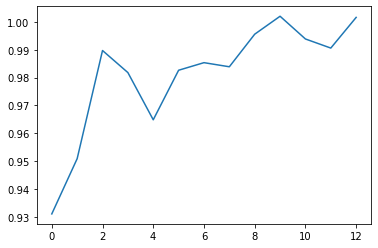

In [24]:
#code for drawing expected (expected + worst) error (distance of interpolator from signal) vs dimension
def calculate_expected_error_for_sample(sample, alpha):    
    """
    Calculates mean of the norm of differences between the interpolators 
    sampled from the interpolator set (given dataset sample) and vector alpha.
    Args:
        sample (tuple): (X,y) pair corresponding to the dataset sampled 
            from the halfspace learning model.
        alpha (np.array): Vector alpha.

    Returns:
        float: Calculated value.
    
    """
    
    w_sample_interpolator=sample_from_interpolator_set(sample, n=200)#n x d
    sample_alpha_diff_norm=calc_sample_alpha_diff_norm(w_sample_interpolator,alpha)#n x 1
    
    return np.mean(sample_alpha_diff_norm)
    
    
d_arr=[i for i in range(2, 15)]
expected_err=[]
for d in d_arr:
    print(d)
    alpha=create_canonic_alpha(d, num_nonzero_el=1)

    expected_err.append(
        np.mean(np.array(
            [calculate_expected_error_for_sample(generate_halfspace_dataset(
                n=d-1, d=d, alpha=alpha, noise=False, noise_sigma=0), alpha) for _ in range(200)]
        )))
    
plt.plot(expected_err)

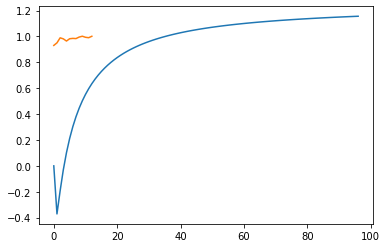

In [30]:
#calculation of lower bound on expected_distance from (33) in report document
from math import e

def lower_bound_val(c, d):
    v1=2**(1/2)
    v2=(1-c/(d-2)**(1/4))**(1/2)
    v3_1=4/(c*(d-2)**(1/4))
    v3_2=e**(-(d-2)**(1/2) * c**2 / 2)
    v3=1-v3_1*v3_2
    
    return v1*v2*v3
    
    
def upper_bound_val(c,d):
    v1=(2)**(1/2)
    v2=8/(c*(d-2)**(1/4))
    return v1+v2
    
    
c=1
d_arr=[i for i in range(3,100)]
lower_bound_vals=[lower_bound_val(c, d) for d in d_arr]

plt.plot(lower_bound_vals)
plt.plot(expected_err)

Academic license - for non-commercial use only - expires 2021-08-31
Using license file /Users/leonardokokot/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0x98886187
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 3 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
x 1
y 0
z 1
Obj: 3


In [34]:
np.max(np.array([1,2,-4]))

2

In [97]:
d,c=30,1

v1=(d-2)**(1/4)
v2=1-(c**2)/(d-2)**(1/2)
v3=1-v2**(1/2)
v4=(v3/2)**(1/2)
s=c/(v1*v4)
print(s)

1.9496488128183487


In [8]:
#max || \alpha - w ||^{2} = || \alpha ||^{2} + ||w||^{2}-2\alpha^{T}w
#s.t. w^{T}(x_{i}y_{i}) >= 0 for all i
#w^{T}w <= 1

#same as

#min w^{T}\alpha
#s.t. w^{T}(x_{i}y_{i}) >= 0 for all i
#w^{T}w <= 1

#since \alpha=(1,0,...,0)

#same as

#min w1
#s.t. w^{T}(x_{i}y_{i}) >= 0 for all i
#w^{T}w <= 1

num_nonzero_el=1
noise,noise_sigma=False,0
sigma=0.5

d_vals=tqdm([25,50,100,250,500,1000])
rand_int_diff, worst_int_diff=np.zeros(len(d_vals)), np.zeros(len(d_vals))
with gp.Env(empty=True) as env:
    env.setParam('LogToConsole', 0)
    env.start()

    for j, d in enumerate(d_vals):
        N=int(d*sigma)

        alpha=create_signal_vector(d, num_nonzero_el=num_nonzero_el) 

        n_iter=5
        rand_int_vals,worst_vals=np.zeros(n_iter),np.zeros(n_iter)
        for i in range(n_iter):
            dataset=generate_halfspace_dataset(N, len(alpha), alpha=alpha, noise=noise, noise_sigma=noise_sigma)
            w_sample_interpolator=sample_from_interpolator_set(dataset, n=50)

            sample_alpha_diff_norm=np.linalg.norm(w_sample_interpolator-alpha, axis=1)

            max_dist_int=find_max_dist_interpolator(dataset, env)

            rand_int_vals[i]=np.mean(sample_alpha_diff_norm)
            worst_vals[i]=np.linalg.norm(max_dist_int-alpha)

        rand_int_diff[j]=np.mean(rand_int_vals)
        worst_int_diff[j]=np.mean(worst_vals)

  0%|          | 0/6 [00:00<?, ?it/s]

Changed value of parameter LogToConsole to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


100%|██████████| 6/6 [7:02:08<00:00, 4221.35s/it]


In [62]:
ww=worst_int_diff
rr=rand_int_diff

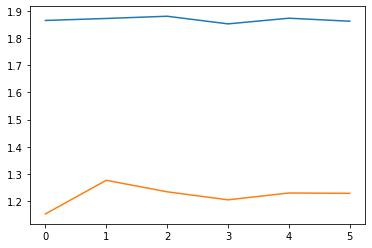

In [9]:
plt.plot(worst_int_diff)
plt.plot(rand_int_diff)

In [48]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

In [23]:
#run this cell in order to obtain the simulation results for typical vs interpolator sets (1)

def sample_typical_vs_worst_interpolator(zeta=0.5, d_vals=[i for i in range(2, 11)], m=100, n_samples=100):
    """
    For each dimension in list d_vals simulates halfspace learning dataset of max(1, int(d*zeta))
    samples m times. For each simulated dataset samples n_samples interpolators and 
    calculates worst case interpolator which are accumulated in np.array and, after 
    the process of simulation is finished, are returned from the function.
    Args:
        zeta (float): Fraction between the size od simulated dataset and dimension d.
        d_vals (list): Contains all values of dimension for which the simulation is ran.
        m (int): Number of simulation runs for each dimension.
        n_samples (int): Number of interpolator sampled for each simulation run.

    Returns:
        tuple: Values obtained from simulations for random 
            interpolators and worst case interpolators.
    
    """
    num_nonzero_el=1
    noise,noise_sigma=False,0

    d_vals=tqdm(d_vals)

    rand_int_diff, worst_int_diff=np.zeros((len(d_vals), m, n_samples)), np.zeros((len(d_vals), m))
    with gp.Env(empty=True) as env:
        env.setParam('LogToConsole', 0)
        env.start()

        for j, d in enumerate(d_vals):
            n=max(1, int(d*zeta))

            alpha=create_signal_vector(d, num_nonzero_el=num_nonzero_el) 

            for i in trange(m):
                dataset=generate_halfspace_dataset(n, d, alpha=alpha, noise=noise, noise_sigma=noise_sigma)
                w_sample_interpolator=sample_from_interpolator_set(dataset, n=n_samples)

                sample_alpha_diff_norm=np.linalg.norm(w_sample_interpolator-alpha, axis=1)

                max_dist_int=find_max_dist_interpolator(dataset, env)
                max_dist_int_diff_norm=np.linalg.norm(max_dist_int-alpha)

                rand_int_diff[j][i]=sample_alpha_diff_norm
                worst_int_diff[j][i]=max_dist_int_diff_norm


    return rand_int_diff, worst_int_diff

def calc_quantile_multiple_d(arr, q=0.01):
    """
    Calculates quantile of np.array for each of arr.shape[0] np.arrays
    obtained by arr[0], arr[1],..., arr[arr.shape[0]-1].
    Args:
        arr (np.array): Contains values to calculate quantiles from.
        q (float): Quantiles to calculate.

    Returns:
        np.array: Quantiles calculated.
    """
    
    shape=arr.shape
    
    assert len(shape)==3
    
    d_len=arr.shape[0]
    
    quantiles=np.zeros(d_len)
    for d in range(d_len):
        sorted_vals=np.sort(arr[d].flatten())
        quantiles[d]=sorted_vals[int(np.ceil(q*np.size(sorted_vals)))-1]
        
    return quantiles

d_vals=[5,10,100,250,500,1000]
rand_int_diff, worst_int_diff=sample_typical_vs_worst_interpolator(zeta=0.3, d_vals=d_vals)

quantiles_low=calc_quantile_multiple_d(rand_int_diff, q=0.01)
quantiles_high=calc_quantile_multiple_d(rand_int_diff, q=0.99)

print(quantiles_low, quantiles_high)

  2%|▏         | 2/100 [00:00<00:07, 12.30it/s]

Changed value of parameter LogToConsole to 0
   Prev: 1  Min: 0  Max: 1  Default: 1



 59%|█████▉    | 59/100 [00:14<00:10,  4.09it/s]


100%|██████████| 6/6 [02:07<00:00, 21.32s/it]

[0.41269684 0.72561965 1.23087921 1.30457693 1.33841443 1.3607439 ] [1.887076   1.80270733 1.564828   1.51418939 1.48493251 1.46394005]


In [24]:
print(rand_int_diff.shape)

(6, 100, 100)


In [25]:
#run this cell in order to obtain the simulation results for typical vs interpolator sets (2)

rand_int_diff_reshaped=np.reshape(rand_int_diff, (rand_int_diff.shape[0], rand_int_diff.shape[1]*rand_int_diff.shape[-1]))
mean_vals=np.mean(rand_int_diff_reshaped, axis=1)

quantiles_low=calc_quantile_multiple_d(rand_int_diff, q=0.001)
quantiles_high=calc_quantile_multiple_d(rand_int_diff, q=0.999)

print(quantiles_low, quantiles_high)
print(mean_vals)

worst_int_diff_min, worst_int_diff_max=np.amin(worst_int_diff, axis=1), np.amax(worst_int_diff, axis=1)
worst_int_mean=np.mean(worst_int_diff, axis=1)

print(worst_int_diff_min, worst_int_diff_max)
print(worst_int_mean)

[0.22039006 0.53542613 1.17172526 1.26106422 1.31111248 1.34500694] [1.95614866 1.87766424 1.6074693  1.55118618 1.50780006 1.48103178]
[1.25623657 1.34375403 1.40732315 1.4112727  1.41279466 1.41365381]
[1.62376513 1.75741184 1.98210265 1.99193622 1.9958323  1.99822362] [1.99995315 1.9999866  1.9999987  1.9999985  1.9999998  1.99999963]
[1.93920878 1.97052507 1.99744772 1.99893702 1.99947403 1.99975828]


In [26]:
#run this cell in order to obtain the simulation results for typical vs interpolator sets (3)

rand_int_diff_reshaped=np.reshape(rand_int_diff, (rand_int_diff.shape[0], rand_int_diff.shape[1]*rand_int_diff.shape[-1]))
vals_arr,dim_arr,typical_vs_worst_case_int=np.array([]),np.array([]),np.array([])
for d,d_val in enumerate(d_vals):
    vals_arr=np.append(vals_arr, rand_int_diff_reshaped[d])
    dim_arr=np.append(dim_arr, [d_val]*rand_int_diff_reshaped.shape[1])
    typical_vs_worst_case_int=np.append(typical_vs_worst_case_int, ['typical']*rand_int_diff_reshaped.shape[1])
    
for d,d_val in enumerate(d_vals):
    vals_arr=np.append(vals_arr, worst_int_diff[d])
    dim_arr=np.append(dim_arr, [d_val]*worst_int_diff.shape[1])
    typical_vs_worst_case_int=np.append(typical_vs_worst_case_int, ['worst']*worst_int_diff.shape[1])
    
dim_arr=dim_arr.astype(int)

In [27]:
#run this cell in order to obtain the simulation results for typical vs interpolator sets (4)


pandas_df=pd.DataFrame({'vals':vals_arr, 'dimension':dim_arr, 'typical_vs_worst':typical_vs_worst_case_int})


In [28]:
#run this cell in order to obtain the simulation results for typical vs interpolator sets (5)

#save data to file

cur_dir=pathlib.Path().resolve()
par_dir=cur_dir.parent

sim_dir=par_dir / 'thesis' / 'sim_data'

if not sim_dir.exists():
    sim_dir.mkdir(parents=True, exist_ok=True)

pandas_df.to_csv('../thesis/sim_data/typical_vs_worst_interpolator_zeta_n_1.csv')

<IPython.core.display.Javascript object>


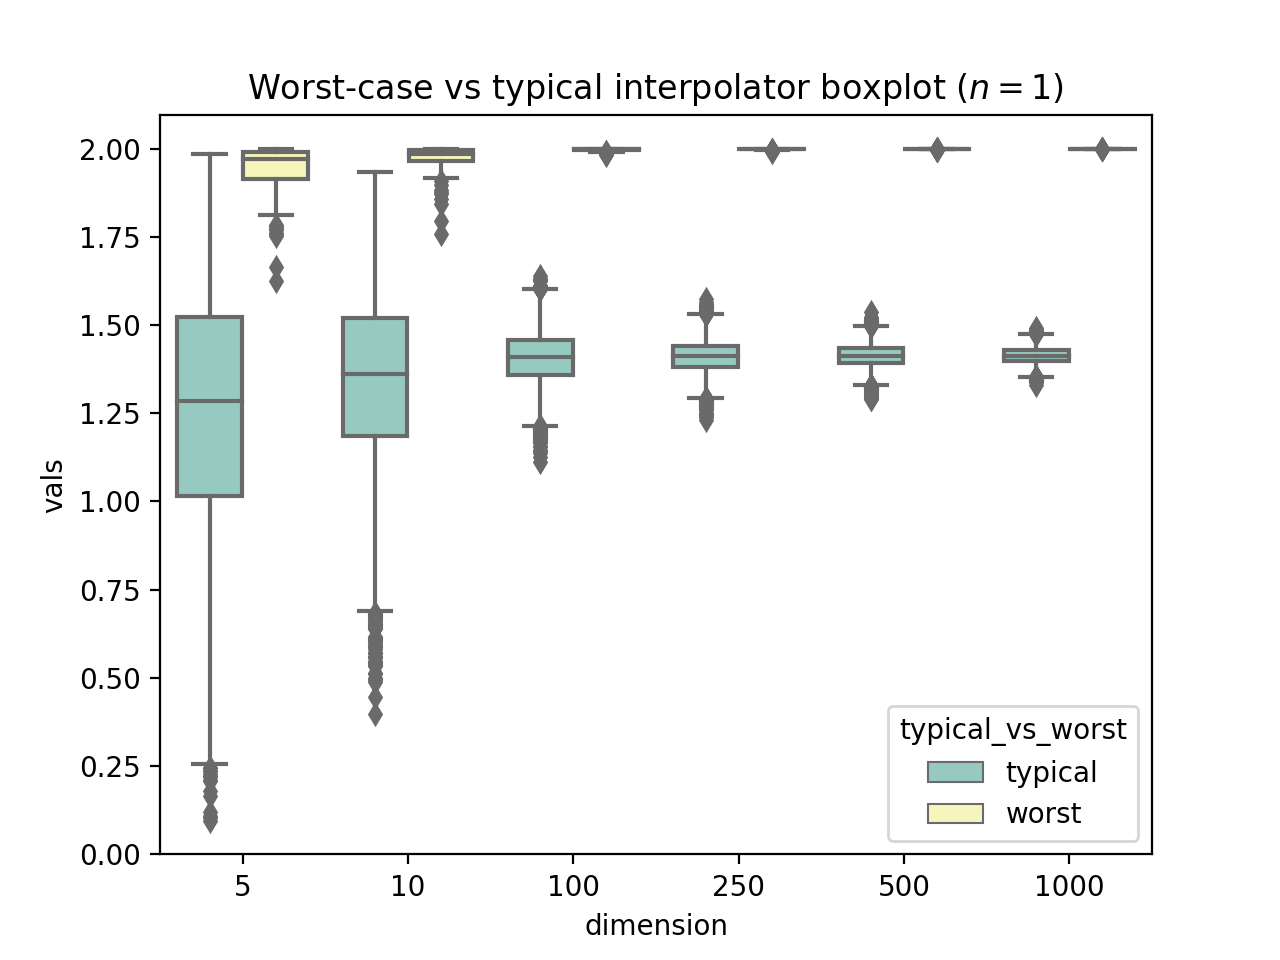

In [30]:
#run this cell in order to obtain the simulation results for typical vs interpolator sets (6)

ax = sns.boxplot(x="dimension", y="vals", hue="typical_vs_worst", data=pandas_df, palette="Set3")
ax.set_title('Worst-case vs typical interpolator boxplot ' + r'($n=1$)')

figure=ax.get_figure()
figure.savefig('../thesis/graphics/typical_vs_worst_interpolator_zeta_n_1.png')

In [70]:
def calc_mean_vals_multiple_d(arr):
    """
    Calculates mean value of the values provided in the np.array
    arr for each element arr[i], where 0<=i<=arr.shape[0]-1.
    Args:
        arr (np.array): Contains values to calculate mean values from.

    Returns:
        np.array: Mean values calculated.
    """
    
    assert len(arr.shape)==3
    
    
    arr_reshaped=np.reshape(arr, (arr.shape[0], arr.shape[1]*arr.shape[-1]))
    return np.mean(arr_reshaped, axis=1)

    
quantiles_low=calc_quantile_multiple_d(rand_int_diff, q=0.001)
quantiles_high=calc_quantile_multiple_d(rand_int_diff, q=0.999)
mean_vals=calc_mean_vals_multiple_d(rand_int_diff)

print('Typical interpolators')

for d, d_val in enumerate([5, 10, 100, 500]):
    print(d_val, quantiles_low[d], quantiles_high[d], mean_vals[d])
  

print('Worst case interpolators')

worst_int_diff_min, worst_int_diff_max=np.amin(worst_int_diff, axis=1), np.amax(worst_int_diff, axis=1)
worst_int_mean=np.mean(worst_int_diff, axis=1)

for d, d_val in enumerate([5, 10, 100, 500]):
    print(d_val, worst_int_diff_min[d], worst_int_diff_max[d], worst_int_mean[d])

Typical interpolators
5 0.18370352561369999 1.8957934982529545 1.118970833817843
10 0.4357645556234992 1.7752210194299798 1.1471016707983999
100 0.9839443745346035 1.4133721100797496 1.1937173945607322
500 1.164263052916775 1.3144432626864968 1.2254339608418299
Worst case interpolators
5 1.618798776652773 1.9799854721102328 1.8489130493481174
10 1.7189053349101915 1.959802932190064 1.8330413410902857
100 1.830232873323023 1.8961397915567122 1.8526516389480072
500 1.8456044122699036 1.8774155662852838 1.8605954870808357


In [7]:
#run this cell in order to obtain the simulation results for the neural network in the appendix

#1 layer neural network equivalent of halfspace learning model

class HalfspaceLearningNN(nn.Module):
    """
    Simple 1-layer neural network model.
    """
    
    def __init__(self, d):
        """
        Constructor.
        Args:
            d (int): Dimension of the input layer.
        """
        
        super().__init__()
        self.net = nn.Sequential(nn.Flatten(1,-1), nn.Linear(d, 2, bias=False))
        

    def forward(self,x):
        """
        Implements forward pass of input data x.
        Args:
            x (torch.tensor): Input data.
        Returns:
            torch.tensor: Output corresponding to the input data.
        """
            
        return self.net(x)
    
def train_network(model, loss_fn, optimizer, train_data, delta=10):    
    """
    Trains the given model.
    Args:
        model (torch.nn.Module): Model.
        loss_fn (torch.nn.loss): Loss function.
        optimizer (torch.nn.optimizer): Optimizer.
        train_data (tuple): Training data. Pair (x,y) torch.tensors. Input data is x,
            while the output data is y.
        delta (float): Margin which has to be obtained by the model
            on the given training data. Serves as a stopping criterion for training the model.
    """
    
    train_x, train_y=train_data
    
    def make_train_step(model, loss_fn, optimizer):
        def train_step(x, y):
            model.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

        return train_step
    
    train_step = make_train_step(model, loss_fn, optimizer)
    while True:
        pred=model(train_x)
        corr_cls_logit=pred[:,train_y].detach()
        corr_cls_logit=corr_cls_logit.numpy()
        wrong_cls_logit=pred[:,1-train_y].detach()
        wrong_cls_logit=wrong_cls_logit.numpy()
        
        if np.min(corr_cls_logit-wrong_cls_logit)>=delta:
            break

        train_step(train_x, train_y)
        
d_vals=tqdm([5, 10, 50, 100, 500, 1000, 5000, 10000])
n_iter=10

err_vals=[]
for d in d_vals:
    
    err_d_vals=[]
    for _ in trange(n_iter):
        num_nonzero_el=1

        noise,noise_sigma=False,0

        N=1

        alpha=create_signal_vector(d, num_nonzero_el=num_nonzero_el) 
        dataset=generate_halfspace_dataset(N, d, alpha=alpha, noise=noise, noise_sigma=noise_sigma)

        dataset_x, dataset_y=dataset
        dataset_y=np.maximum(dataset_y, np.zeros(dataset_y.shape))#go from classes being -1 and 1 into 0 and 1

        dataset_x, dataset_y=torch.from_numpy(dataset_x), torch.from_numpy(dataset_y)
        dataset_x, dataset_y=dataset_x.float(), dataset_y.long()
        train_data=(dataset_x, dataset_y)

        model=HalfspaceLearningNN(d)
        
        loss_fn=nn.CrossEntropyLoss()

        LEARNING_RATE=0.1
        optimizer=torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

        init_param=next(model.parameters()).detach().numpy().copy()
        train_network(model, loss_fn, optimizer, train_data)
        final_param=next(model.parameters()).detach().numpy()

        diff_param=final_param-init_param

        err=np.linalg.norm(diff_param)
        
        err_d_vals.append(err)
        
    err_vals.append(err_d_vals)
    
err_vals=np.array(err_vals)
mean_err_vals=np.mean(err_vals, axis=1)

print(mean_err_vals)

100%|██████████| 8/8 [46:01<00:00, 345.23s/it]

[3.5176773  2.2832522  1.0789137  0.80809486 1.4026413  2.1472933
 4.899695   8.319525  ]


In [39]:
#1 layer neural network equivalent of halfspace learning model

class HalfspaceLearningNN(nn.Module):
    """
    Simple 1-layer neural network model.
    """
    
    def __init__(self, d):
        """
        Constructor.
        Args:
            d (int): Dimension of the input layer.
        """
        super().__init__()
        self.net = nn.Sequential(nn.Flatten(1,-1), nn.Linear(d, 2, bias=False))
        

    def forward(self,x):
        """
        Implements forward pass of input data x.
        Args:
            x (torch.tensor): Input data.
        Returns:
            torch.tensor: Output corresponding to the input data.
        """
        return self.net(x)
    
def train_network(model, loss_fn, optimizer, train_data, delta=10):  
    """
    Trains the given model.
    Args:
        model (torch.nn.Module): Model.
        loss_fn (torch.nn.loss): Loss function.
        optimizer (torch.nn.optimizer): Optimizer.
        train_data (tuple): Training data. Pair (x,y) torch.tensors. Input data is x,
            while the output data is y.
        delta (float): Margin which has to be obtained by the model
            on the given training data. Serves as a stopping criterion for training the model.
    """
    
    train_x, train_y=train_data
    train_y_np=train_y.numpy()
    
    def make_train_step(model, loss_fn, optimizer):
        def train_step(x, y):
            model.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

        return train_step
    
    train_step = make_train_step(model, loss_fn, optimizer)
    while True:
        pred=model(train_x).detach()
        pred=pred.numpy()
        
        corr_cls_logit=np.choose(train_y_np, pred.T)
        wrong_cls_logit=np.choose(1-train_y_np, pred.T)
        if np.min(corr_cls_logit-wrong_cls_logit)>=delta:
            print(train_x.shape[1], np.min(corr_cls_logit-wrong_cls_logit))
            break

        train_step(train_x, train_y)

zeta=0.3
d_vals=tqdm([10,100,1000])
n_iter=100

err_vals=[]
for d in d_vals:
    
    err_d_vals=[]
    for i in trange(n_iter):
        num_nonzero_el=1

        noise,noise_sigma=False,0

        N=max(1, int(d*zeta))#size of train dataset

        alpha=create_signal_vector(d, num_nonzero_el=num_nonzero_el) 
        dataset=generate_halfspace_dataset(N, d, alpha=alpha, noise=noise, noise_sigma=noise_sigma)

        dataset_x, dataset_y=dataset
        dataset_x /= np.linalg.norm(dataset_x, axis=1)[:,None]#normalize each x_{i}

        dataset_y=np.maximum(dataset_y, np.zeros(dataset_y.shape))#go from classes being -1 and 1 into 0 and 1

        dataset_x, dataset_y=torch.from_numpy(dataset_x), torch.from_numpy(dataset_y)
        dataset_x, dataset_y=dataset_x.float(), dataset_y.long()
        train_data=(dataset_x, dataset_y)

        model=HalfspaceLearningNN(d)
                
        loss_fn=nn.CrossEntropyLoss()

        LEARNING_RATE=d**(1.2)*zeta
        optimizer=torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
        
        init_param=next(model.parameters()).detach().numpy().copy()
        train_network(model, loss_fn, optimizer, train_data)
        final_param=next(model.parameters()).detach().numpy()

        diff_param=final_param-init_param

        err=np.linalg.norm(diff_param)
        
        err_d_vals.append(err)
        
    err_vals.append(err_d_vals)
    
err_vals=np.array(err_vals)
mean_err_vals=np.mean(err_vals, axis=1)

print(mean_err_vals)

  1%|          | 1/100 [00:00<01:13,  1.36it/s]

10 10.000011



  2%|▏         | 2/100 [00:01<00:51,  1.89it/s]

10 10.000124



  3%|▎         | 3/100 [00:01<00:51,  1.87it/s]

10 10.000119



  4%|▍         | 4/100 [00:02<00:49,  1.95it/s]

10 10.000002



  5%|▌         | 5/100 [00:02<00:56,  1.67it/s]

10 10.000077



  6%|▌         | 6/100 [00:03<00:56,  1.67it/s]

10 10.000002



  7%|▋         | 7/100 [00:04<00:53,  1.73it/s]

10 10.000137



  8%|▊         | 8/100 [00:05<01:18,  1.18it/s]

10 10.00001



  9%|▉         | 9/100 [00:07<01:57,  1.29s/it]

10 10.000017



 10%|█         | 10/100 [00:09<02:09,  1.44s/it]

10 10.000001



 11%|█         | 11/100 [00:09<01:37,  1.09s/it]

10 10.000183



 12%|█▏        | 12/100 [00:10<01:21,  1.08it/s]

10 10.00004



 13%|█▎        | 13/100 [00:11<01:19,  1.09it/s]

10 10.000063



 14%|█▍        | 14/100 [00:11<01:03,  1.36it/s]

10 10.000158



 15%|█▌        | 15/100 [00:11<00:53,  1.59it/s]

10 10.000122



 16%|█▌        | 16/100 [00:12<00:45,  1.85it/s]

10 10.000114



 17%|█▋        | 17/100 [00:13<00:55,  1.49it/s]

10 10.000057



 18%|█▊        | 18/100 [00:14<01:00,  1.35it/s]

10 10.000084



 19%|█▉        | 19/100 [00:15<01:06,  1.23it/s]

10 10.000008



 20%|██        | 20/100 [00:15<00:54,  1.46it/s]

10 10.0



 21%|██        | 21/100 [00:15<00:46,  1.71it/s]

10 10.00001



 22%|██▏       | 22/100 [00:16<00:40,  1.91it/s]

10 10.000078



 23%|██▎       | 23/100 [00:16<00:42,  1.82it/s]

10 10.000071



 24%|██▍       | 24/100 [00:17<00:39,  1.91it/s]

10 10.000019



 25%|██▌       | 25/100 [00:18<00:52,  1.43it/s]

10 10.000065



 26%|██▌       | 26/100 [00:19<00:58,  1.27it/s]

10 10.000052



 27%|██▋       | 27/100 [00:20<01:06,  1.10it/s]

10 10.000013



 28%|██▊       | 28/100 [00:21<00:57,  1.25it/s]

10 10.000076



 29%|██▉       | 29/100 [00:21<00:55,  1.29it/s]

10 10.000011



 30%|███       | 30/100 [00:22<00:46,  1.52it/s]

10 10.000146



 31%|███       | 31/100 [00:23<00:47,  1.46it/s]

10 10.000013



 32%|███▏      | 32/100 [00:23<00:40,  1.69it/s]

10 10.000004



 33%|███▎      | 33/100 [00:23<00:38,  1.74it/s]

10 10.000131



 34%|███▍      | 34/100 [00:24<00:39,  1.67it/s]

10 10.0000305



 35%|███▌      | 35/100 [00:25<00:40,  1.61it/s]

10 10.000027



 36%|███▌      | 36/100 [00:25<00:37,  1.70it/s]

10 10.000113



 37%|███▋      | 37/100 [00:27<00:51,  1.22it/s]

10 10.00005



 38%|███▊      | 38/100 [00:27<00:42,  1.46it/s]

10 10.000174



 39%|███▉      | 39/100 [00:27<00:37,  1.61it/s]

10 10.000074



 40%|████      | 40/100 [00:28<00:44,  1.35it/s]

10 10.000038



 41%|████      | 41/100 [00:29<00:40,  1.46it/s]

10 10.000085



 42%|████▏     | 42/100 [00:30<00:37,  1.54it/s]

10 10.000113



 43%|████▎     | 43/100 [00:31<00:42,  1.34it/s]

10 10.000035



 44%|████▍     | 44/100 [00:31<00:41,  1.35it/s]

10 10.000053



 45%|████▌     | 45/100 [00:32<00:36,  1.53it/s]

10 10.000149



 46%|████▌     | 46/100 [00:32<00:34,  1.58it/s]

10 10.000024



 47%|████▋     | 47/100 [00:33<00:31,  1.66it/s]

10 10.000017



 48%|████▊     | 48/100 [00:33<00:28,  1.81it/s]

10 10.000083



 49%|████▉     | 49/100 [00:34<00:29,  1.74it/s]

10 10.000107



 50%|█████     | 50/100 [00:35<00:29,  1.72it/s]

10 10.000069



 51%|█████     | 51/100 [00:35<00:27,  1.79it/s]

10 10.000077



 52%|█████▏    | 52/100 [00:35<00:23,  2.05it/s]

10 10.000151



 53%|█████▎    | 53/100 [00:36<00:24,  1.91it/s]

10 10.000103



 54%|█████▍    | 54/100 [00:37<00:26,  1.74it/s]

10 10.000035



 55%|█████▌    | 55/100 [00:38<00:30,  1.47it/s]

10 10.000045



 56%|█████▌    | 56/100 [00:39<00:33,  1.32it/s]

10 10.000042



 57%|█████▋    | 57/100 [00:39<00:34,  1.25it/s]

10 10.000031



 58%|█████▊    | 58/100 [00:40<00:35,  1.18it/s]

10 10.000026



 59%|█████▉    | 59/100 [00:41<00:30,  1.36it/s]

10 10.000138



 60%|██████    | 60/100 [00:41<00:26,  1.50it/s]

10 10.000008



 61%|██████    | 61/100 [00:42<00:23,  1.67it/s]

10 10.000135



 62%|██████▏   | 62/100 [00:44<00:39,  1.04s/it]

10 10.0000105



 63%|██████▎   | 63/100 [00:45<00:36,  1.02it/s]

10 10.000024



 64%|██████▍   | 64/100 [00:47<00:51,  1.42s/it]

10 10.000008



 65%|██████▌   | 65/100 [00:48<00:41,  1.17s/it]

10 10.000111



 66%|██████▌   | 66/100 [00:49<00:38,  1.12s/it]

10 10.000048



 67%|██████▋   | 67/100 [00:49<00:29,  1.12it/s]

10 10.000117



 68%|██████▊   | 68/100 [00:52<00:49,  1.56s/it]

10 10.000002



 69%|██████▉   | 69/100 [00:53<00:37,  1.22s/it]

10 10.000031



 70%|███████   | 70/100 [00:53<00:33,  1.11s/it]

10 10.0000515



 71%|███████   | 71/100 [00:54<00:27,  1.05it/s]

10 10.0000725



 72%|███████▏  | 72/100 [00:55<00:25,  1.11it/s]

10 10.000092



 73%|███████▎  | 73/100 [00:56<00:26,  1.02it/s]

10 10.0000105



 74%|███████▍  | 74/100 [00:57<00:28,  1.11s/it]

10 10.000031



 75%|███████▌  | 75/100 [00:59<00:28,  1.13s/it]

10 10.00001



 76%|███████▌  | 76/100 [00:59<00:21,  1.11it/s]

10 10.000063



 77%|███████▋  | 77/100 [01:01<00:26,  1.16s/it]

10 10.000029



 78%|███████▊  | 78/100 [01:01<00:21,  1.01it/s]

10 10.000023



 79%|███████▉  | 79/100 [01:02<00:17,  1.18it/s]

10 10.000071



 80%|████████  | 80/100 [01:02<00:15,  1.33it/s]

10 10.000113



 81%|████████  | 81/100 [01:04<00:18,  1.04it/s]

10 10.000046



 82%|████████▏ | 82/100 [01:05<00:17,  1.05it/s]

10 10.000023



 83%|████████▎ | 83/100 [01:05<00:15,  1.13it/s]

10 10.000092



 84%|████████▍ | 84/100 [01:06<00:12,  1.29it/s]

10 10.000115



 85%|████████▌ | 85/100 [01:07<00:11,  1.33it/s]

10 10.000016



 86%|████████▌ | 86/100 [01:07<00:09,  1.42it/s]

10 10.000104



 87%|████████▋ | 87/100 [01:08<00:08,  1.60it/s]

10 10.000092



 88%|████████▊ | 88/100 [01:09<00:08,  1.40it/s]

10 10.000011



 89%|████████▉ | 89/100 [01:09<00:07,  1.44it/s]

10 10.000053



 90%|█████████ | 90/100 [01:10<00:06,  1.64it/s]

10 10.000174



 91%|█████████ | 91/100 [01:11<00:08,  1.09it/s]

10 10.000016



 92%|█████████▏| 92/100 [01:12<00:07,  1.13it/s]

10 10.000019



 93%|█████████▎| 93/100 [01:14<00:08,  1.17s/it]

10 10.0000105



 94%|█████████▍| 94/100 [01:15<00:06,  1.10s/it]

10 10.000048



 95%|█████████▌| 95/100 [01:16<00:05,  1.03s/it]

10 10.000008



 96%|█████████▌| 96/100 [01:17<00:04,  1.18s/it]

10 10.000034



 97%|█████████▋| 97/100 [01:19<00:03,  1.20s/it]

10 10.000054



 98%|█████████▊| 98/100 [01:19<00:02,  1.06s/it]

10 10.000046



 99%|█████████▉| 99/100 [01:20<00:00,  1.02it/s]

10 10.000027



  0%|          | 0/100 [00:00<?, ?it/s]

10 10.000048



  1%|          | 1/100 [00:01<02:01,  1.23s/it]

100 10.000048



  2%|▏         | 2/100 [00:01<01:30,  1.08it/s]

100 10.000111



  3%|▎         | 3/100 [00:02<01:31,  1.06it/s]

100 10.000053



  4%|▍         | 4/100 [00:03<01:23,  1.15it/s]

100 10.000069



  5%|▌         | 5/100 [00:04<01:21,  1.17it/s]

100 10.000082



  6%|▌         | 6/100 [00:05<01:21,  1.16it/s]

100 10.000071



  7%|▋         | 7/100 [00:06<01:18,  1.19it/s]

100 10.000021



  8%|▊         | 8/100 [00:06<01:15,  1.22it/s]

100 10.000093



  9%|▉         | 9/100 [00:08<01:22,  1.11it/s]

100 10.000021



 10%|█         | 10/100 [00:09<01:29,  1.01it/s]

100 10.000071



 11%|█         | 11/100 [00:10<01:41,  1.14s/it]

100 10.000029



 12%|█▏        | 12/100 [00:12<01:46,  1.21s/it]

100 10.000011



 13%|█▎        | 13/100 [00:13<01:40,  1.15s/it]

100 10.000041



 14%|█▍        | 14/100 [00:13<01:27,  1.02s/it]

100 10.00009



 15%|█▌        | 15/100 [00:14<01:30,  1.07s/it]

100 10.000022



 16%|█▌        | 16/100 [00:16<01:28,  1.06s/it]

100 10.000037



 17%|█▋        | 17/100 [00:16<01:23,  1.01s/it]

100 10.000084



 18%|█▊        | 18/100 [00:17<01:20,  1.02it/s]

100 10.000013



 19%|█▉        | 19/100 [00:18<01:17,  1.05it/s]

100 10.000063



 20%|██        | 20/100 [00:19<01:16,  1.04it/s]

100 10.000065



 21%|██        | 21/100 [00:20<01:13,  1.07it/s]

100 10.000069



 22%|██▏       | 22/100 [00:21<01:09,  1.12it/s]

100 10.000065



 23%|██▎       | 23/100 [00:22<01:10,  1.09it/s]

100 10.00001



 24%|██▍       | 24/100 [00:23<01:07,  1.13it/s]

100 10.00008



 25%|██▌       | 25/100 [00:23<01:03,  1.17it/s]

100 10.000092



 26%|██▌       | 26/100 [00:24<01:04,  1.15it/s]

100 10.000008



 27%|██▋       | 27/100 [00:25<01:03,  1.15it/s]

100 10.000024



 28%|██▊       | 28/100 [00:26<01:03,  1.13it/s]

100 10.000025



 29%|██▉       | 29/100 [00:27<01:00,  1.17it/s]

100 10.000046



 30%|███       | 30/100 [00:28<00:58,  1.19it/s]

100 10.000019



 31%|███       | 31/100 [00:29<01:04,  1.07it/s]

100 10.000046



 32%|███▏      | 32/100 [00:30<01:01,  1.10it/s]

100 10.000065



 33%|███▎      | 33/100 [00:31<01:03,  1.06it/s]

100 10.0000515



 34%|███▍      | 34/100 [00:32<01:01,  1.08it/s]

100 10.000019



 35%|███▌      | 35/100 [00:33<01:01,  1.06it/s]

100 10.000042



 36%|███▌      | 36/100 [00:33<00:58,  1.10it/s]

100 10.00001



 37%|███▋      | 37/100 [00:34<00:53,  1.18it/s]

100 10.000008



 38%|███▊      | 38/100 [00:35<00:58,  1.06it/s]

100 10.000034



 39%|███▉      | 39/100 [00:36<00:56,  1.08it/s]

100 10.000082



 40%|████      | 40/100 [00:37<00:54,  1.10it/s]

100 10.000052



 41%|████      | 41/100 [00:38<00:49,  1.19it/s]

100 10.000044



 42%|████▏     | 42/100 [00:39<00:50,  1.15it/s]

100 10.00004



 43%|████▎     | 43/100 [00:40<00:52,  1.08it/s]

100 10.000036



 44%|████▍     | 44/100 [00:41<00:50,  1.10it/s]

100 10.000006



 45%|████▌     | 45/100 [00:42<00:49,  1.10it/s]

100 10.000032



 46%|████▌     | 46/100 [00:42<00:46,  1.16it/s]

100 10.000012



 47%|████▋     | 47/100 [00:43<00:49,  1.08it/s]

100 10.0000515



 48%|████▊     | 48/100 [00:45<00:52,  1.00s/it]

100 10.000057



 49%|████▉     | 49/100 [00:45<00:49,  1.03it/s]

100 10.000065



 50%|█████     | 50/100 [00:46<00:46,  1.07it/s]

100 10.000025



 51%|█████     | 51/100 [00:47<00:44,  1.10it/s]

100 10.000005



 52%|█████▏    | 52/100 [00:48<00:46,  1.03it/s]

100 10.000002



 53%|█████▎    | 53/100 [00:49<00:44,  1.05it/s]

100 10.000033



 54%|█████▍    | 54/100 [00:50<00:46,  1.01s/it]

100 10.000016



 55%|█████▌    | 55/100 [00:51<00:41,  1.07it/s]

100 10.000023



 56%|█████▌    | 56/100 [00:52<00:40,  1.08it/s]

100 10.000067



 57%|█████▋    | 57/100 [00:53<00:37,  1.13it/s]

100 10.000103



 58%|█████▊    | 58/100 [00:54<00:39,  1.07it/s]

100 10.000051



 59%|█████▉    | 59/100 [00:55<00:38,  1.06it/s]

100 10.000046



 60%|██████    | 60/100 [00:56<00:37,  1.07it/s]

100 10.000002



 61%|██████    | 61/100 [00:57<00:36,  1.06it/s]

100 10.000047



 62%|██████▏   | 62/100 [00:57<00:33,  1.13it/s]

100 10.000017



 63%|██████▎   | 63/100 [00:58<00:34,  1.06it/s]

100 10.000057



 64%|██████▍   | 64/100 [00:59<00:32,  1.11it/s]

100 10.000015



 65%|██████▌   | 65/100 [01:00<00:32,  1.08it/s]

100 10.00004



 66%|██████▌   | 66/100 [01:01<00:29,  1.17it/s]

100 10.000017



 67%|██████▋   | 67/100 [01:02<00:28,  1.14it/s]

100 10.000061



 68%|██████▊   | 68/100 [01:03<00:29,  1.10it/s]

100 10.000013



 69%|██████▉   | 69/100 [01:04<00:28,  1.10it/s]

100 10.000023



 70%|███████   | 70/100 [01:04<00:25,  1.17it/s]

100 10.0000725



 71%|███████   | 71/100 [01:05<00:25,  1.12it/s]

100 10.000023



 72%|███████▏  | 72/100 [01:06<00:25,  1.11it/s]

100 10.000048



 73%|███████▎  | 73/100 [01:07<00:24,  1.10it/s]

100 10.0000725



 74%|███████▍  | 74/100 [01:08<00:23,  1.11it/s]

100 10.000042



 75%|███████▌  | 75/100 [01:09<00:23,  1.08it/s]

100 10.000063



 76%|███████▌  | 76/100 [01:10<00:24,  1.00s/it]

100 10.000039



 77%|███████▋  | 77/100 [01:11<00:22,  1.03it/s]

100 10.000022



 78%|███████▊  | 78/100 [01:12<00:21,  1.03it/s]

100 10.0



 79%|███████▉  | 79/100 [01:13<00:20,  1.04it/s]

100 10.000084



 80%|████████  | 80/100 [01:14<00:17,  1.13it/s]

100 10.000059



 81%|████████  | 81/100 [01:15<00:16,  1.13it/s]

100 10.000011



 82%|████████▏ | 82/100 [01:16<00:15,  1.15it/s]

100 10.000018



 83%|████████▎ | 83/100 [01:16<00:14,  1.18it/s]

100 10.000039



 84%|████████▍ | 84/100 [01:17<00:11,  1.34it/s]

100 10.00008



 85%|████████▌ | 85/100 [01:18<00:11,  1.33it/s]

100 10.000089



 86%|████████▌ | 86/100 [01:19<00:11,  1.20it/s]

100 10.000071



 87%|████████▋ | 87/100 [01:19<00:09,  1.31it/s]

100 10.000031



 88%|████████▊ | 88/100 [01:20<00:09,  1.24it/s]

100 10.000002



 89%|████████▉ | 89/100 [01:21<00:10,  1.10it/s]

100 10.000067



 90%|█████████ | 90/100 [01:22<00:08,  1.25it/s]

100 10.0001335



 91%|█████████ | 91/100 [01:23<00:08,  1.06it/s]

100 10.0000305



 92%|█████████▏| 92/100 [01:24<00:07,  1.10it/s]

100 10.000004



 93%|█████████▎| 93/100 [01:25<00:06,  1.08it/s]

100 10.000071



 94%|█████████▍| 94/100 [01:26<00:04,  1.20it/s]

100 10.000126



 95%|█████████▌| 95/100 [01:26<00:04,  1.20it/s]

100 10.000099



 96%|█████████▌| 96/100 [01:28<00:03,  1.06it/s]

100 10.000017



 97%|█████████▋| 97/100 [01:29<00:02,  1.01it/s]

100 10.000016



 98%|█████████▊| 98/100 [01:29<00:01,  1.14it/s]

100 10.000013



 99%|█████████▉| 99/100 [01:30<00:00,  1.15it/s]

100 10.000006



  0%|          | 0/100 [00:00<?, ?it/s]

100 10.000034



  1%|          | 1/100 [00:03<06:22,  3.86s/it]

1000 10.000032



  2%|▏         | 2/100 [00:07<06:19,  3.87s/it]

1000 10.000013



  3%|▎         | 3/100 [00:12<06:36,  4.09s/it]

1000 10.0



  4%|▍         | 4/100 [00:16<06:48,  4.25s/it]

1000 10.000043



  5%|▌         | 5/100 [00:21<06:54,  4.36s/it]

1000 10.000019



  6%|▌         | 6/100 [00:25<06:54,  4.41s/it]

1000 10.000068



  7%|▋         | 7/100 [00:30<07:03,  4.55s/it]

1000 10.000087



  8%|▊         | 8/100 [00:35<07:10,  4.68s/it]

1000 10.000042



  9%|▉         | 9/100 [00:40<07:23,  4.87s/it]

1000 10.000063



 10%|█         | 10/100 [00:45<07:04,  4.71s/it]

1000 10.000036



 11%|█         | 11/100 [00:49<06:58,  4.70s/it]

1000 10.000095



 12%|█▏        | 12/100 [00:54<06:42,  4.57s/it]

1000 10.000029



 13%|█▎        | 13/100 [00:58<06:22,  4.40s/it]

1000 10.000099



 14%|█▍        | 14/100 [01:02<06:10,  4.31s/it]

1000 10.000111



 15%|█▌        | 15/100 [01:06<05:57,  4.21s/it]

1000 10.000059



 16%|█▌        | 16/100 [01:10<06:01,  4.31s/it]

1000 10.000084



 17%|█▋        | 17/100 [01:15<05:58,  4.31s/it]

1000 10.000097



 18%|█▊        | 18/100 [01:19<05:58,  4.37s/it]

1000 10.000067



 19%|█▉        | 19/100 [01:24<06:17,  4.66s/it]

1000 10.000008



 20%|██        | 20/100 [01:29<06:10,  4.63s/it]

1000 10.000013



 21%|██        | 21/100 [01:33<06:04,  4.62s/it]

1000 10.000036



 22%|██▏       | 22/100 [01:38<05:52,  4.52s/it]

1000 10.00001



 23%|██▎       | 23/100 [01:42<05:44,  4.47s/it]

1000 10.000084



 24%|██▍       | 24/100 [01:47<05:41,  4.50s/it]

1000 10.000101



 25%|██▌       | 25/100 [01:51<05:27,  4.37s/it]

1000 10.000042



 26%|██▌       | 26/100 [01:55<05:28,  4.43s/it]

1000 10.00009



 27%|██▋       | 27/100 [02:00<05:30,  4.53s/it]

1000 10.000008



 28%|██▊       | 28/100 [02:05<05:23,  4.49s/it]

1000 10.000085



 29%|██▉       | 29/100 [02:09<05:20,  4.51s/it]

1000 10.000067



 30%|███       | 30/100 [02:14<05:16,  4.53s/it]

1000 10.00005



 31%|███       | 31/100 [02:18<05:04,  4.42s/it]

1000 10.00004



 32%|███▏      | 32/100 [02:23<05:16,  4.66s/it]

1000 10.000082



 33%|███▎      | 33/100 [02:27<05:01,  4.50s/it]

1000 10.000041



 34%|███▍      | 34/100 [02:32<04:58,  4.52s/it]

1000 10.000092



 35%|███▌      | 35/100 [02:37<05:12,  4.81s/it]

1000 10.0



 36%|███▌      | 36/100 [02:41<04:58,  4.66s/it]

1000 10.000105



 37%|███▋      | 37/100 [02:46<04:49,  4.60s/it]

1000 10.000069



 38%|███▊      | 38/100 [02:51<04:49,  4.67s/it]

1000 10.000086



 39%|███▉      | 39/100 [02:55<04:32,  4.47s/it]

1000 10.000032



 40%|████      | 40/100 [02:59<04:21,  4.35s/it]

1000 10.000019



 41%|████      | 41/100 [03:04<04:31,  4.60s/it]

1000 10.000015



 42%|████▏     | 42/100 [03:09<04:35,  4.76s/it]

1000 10.000005



 43%|████▎     | 43/100 [03:13<04:19,  4.54s/it]

1000 10.000077



 44%|████▍     | 44/100 [03:19<04:27,  4.78s/it]

1000 10.000013



 45%|████▌     | 45/100 [03:23<04:14,  4.62s/it]

1000 10.000048



 46%|████▌     | 46/100 [03:27<04:05,  4.54s/it]

1000 10.000029



 47%|████▋     | 47/100 [03:32<04:09,  4.71s/it]

1000 10.000074



 48%|████▊     | 48/100 [03:37<04:10,  4.81s/it]

1000 10.000002



 49%|████▉     | 49/100 [03:42<04:02,  4.75s/it]

1000 10.000061



 50%|█████     | 50/100 [03:46<03:50,  4.60s/it]

1000 10.000034



 51%|█████     | 51/100 [03:51<03:54,  4.79s/it]

1000 10.000047



 52%|█████▏    | 52/100 [03:56<03:40,  4.60s/it]

1000 10.000048



 53%|█████▎    | 53/100 [04:00<03:31,  4.50s/it]

1000 10.000057



 54%|█████▍    | 54/100 [04:04<03:22,  4.41s/it]

1000 10.000034



 55%|█████▌    | 55/100 [04:08<03:14,  4.33s/it]

1000 10.000012



 56%|█████▌    | 56/100 [04:13<03:11,  4.35s/it]

1000 10.000033



 57%|█████▋    | 57/100 [04:17<03:07,  4.35s/it]

1000 10.000065



 58%|█████▊    | 58/100 [04:21<03:01,  4.31s/it]

1000 10.00008



 59%|█████▉    | 59/100 [04:26<02:57,  4.32s/it]

1000 10.000013



 60%|██████    | 60/100 [04:31<03:02,  4.56s/it]

1000 10.000041



 61%|██████    | 61/100 [04:35<02:55,  4.49s/it]

1000 10.0000305



 62%|██████▏   | 62/100 [04:40<02:55,  4.62s/it]

1000 10.0



 63%|██████▎   | 63/100 [04:45<02:52,  4.66s/it]

1000 10.000011



 64%|██████▍   | 64/100 [04:49<02:47,  4.67s/it]

1000 10.000059



 65%|██████▌   | 65/100 [04:54<02:39,  4.56s/it]

1000 10.000002



 66%|██████▌   | 66/100 [04:58<02:37,  4.63s/it]

1000 10.000029



 67%|██████▋   | 67/100 [05:03<02:33,  4.64s/it]

1000 10.000042



 68%|██████▊   | 68/100 [05:08<02:27,  4.61s/it]

1000 10.000048



 69%|██████▉   | 69/100 [05:13<02:27,  4.74s/it]

1000 10.000067



 70%|███████   | 70/100 [05:18<02:26,  4.87s/it]

1000 10.00004



 71%|███████   | 71/100 [05:23<02:20,  4.84s/it]

1000 10.000017



 72%|███████▏  | 72/100 [05:27<02:12,  4.72s/it]

1000 10.00012



 73%|███████▎  | 73/100 [05:32<02:12,  4.90s/it]

1000 10.000108



 74%|███████▍  | 74/100 [05:38<02:15,  5.20s/it]

1000 10.000007



 75%|███████▌  | 75/100 [05:44<02:16,  5.44s/it]

1000 10.000004



 76%|███████▌  | 76/100 [05:49<02:02,  5.11s/it]

1000 10.000105



 77%|███████▋  | 77/100 [05:52<01:47,  4.68s/it]

1000 10.000064



 78%|███████▊  | 78/100 [05:57<01:41,  4.63s/it]

1000 10.000002



 79%|███████▉  | 79/100 [06:03<01:45,  5.03s/it]

1000 10.000017



 80%|████████  | 80/100 [06:08<01:39,  4.96s/it]

1000 10.000118



 81%|████████  | 81/100 [06:14<01:40,  5.28s/it]

1000 10.000055



 82%|████████▏ | 82/100 [06:18<01:28,  4.94s/it]

1000 10.000023



 83%|████████▎ | 83/100 [06:23<01:24,  5.00s/it]

1000 10.000043



 84%|████████▍ | 84/100 [06:27<01:17,  4.87s/it]

1000 10.000091



 85%|████████▌ | 85/100 [06:33<01:14,  4.94s/it]

1000 10.000099



 86%|████████▌ | 86/100 [06:37<01:06,  4.78s/it]

1000 10.000042



 87%|████████▋ | 87/100 [06:42<01:01,  4.76s/it]

1000 10.000096



 88%|████████▊ | 88/100 [06:47<00:58,  4.84s/it]

1000 10.000036



 89%|████████▉ | 89/100 [06:52<00:54,  4.93s/it]

1000 10.000071



 90%|█████████ | 90/100 [06:56<00:47,  4.77s/it]

1000 10.000019



 91%|█████████ | 91/100 [07:01<00:43,  4.79s/it]

1000 10.000069



 92%|█████████▏| 92/100 [07:05<00:36,  4.62s/it]

1000 10.000079



 93%|█████████▎| 93/100 [07:11<00:33,  4.80s/it]

1000 10.00004



 94%|█████████▍| 94/100 [07:15<00:27,  4.66s/it]

1000 10.000025



 95%|█████████▌| 95/100 [07:19<00:22,  4.52s/it]

1000 10.00008



 96%|█████████▌| 96/100 [07:23<00:17,  4.37s/it]

1000 10.0000515



 97%|█████████▋| 97/100 [07:28<00:13,  4.54s/it]

1000 10.000097



 98%|█████████▊| 98/100 [07:33<00:09,  4.69s/it]

1000 10.000103



 99%|█████████▉| 99/100 [07:38<00:04,  4.68s/it]

1000 10.000095



100%|██████████| 3/3 [10:35<00:00, 211.89s/it]

1000 10.000046
[ 13.407622  43.688297 143.51344 ]


In [41]:
n_iter=err_vals.shape[1]
err_vals=err_vals.flatten()

d_vals=[10, 100, 1000]

num_els=len(err_vals)
df=pd.DataFrame(columns=['frobenius_norm_of_wights_diff', 'dimension'])
for i in range(num_els):
    d=d_vals[i//n_iter]
    df=pd.concat([df, pd.DataFrame([[err_vals[i], d]],columns=['frobenius_norm_of_wights_diff', 'dimension'])])
    
print(df)
    
#pandas_df=pd.DataFrame({'vals':vals_arr, 'dimension':dim_arr, 'typical_vs_worst':typical_vs_worst_case_int})

    frobenius_norm_of_wights_diff dimension
0                       14.009645        10
0                        9.480792        10
0                       11.634019        10
0                       10.465517        10
0                       13.932279        10
..                            ...       ...
0                      140.638168      1000
0                      145.882202      1000
0                      146.369202      1000
0                      143.054459      1000
0                      142.321991      1000

[300 rows x 2 columns]


<IPython.core.display.Javascript object>


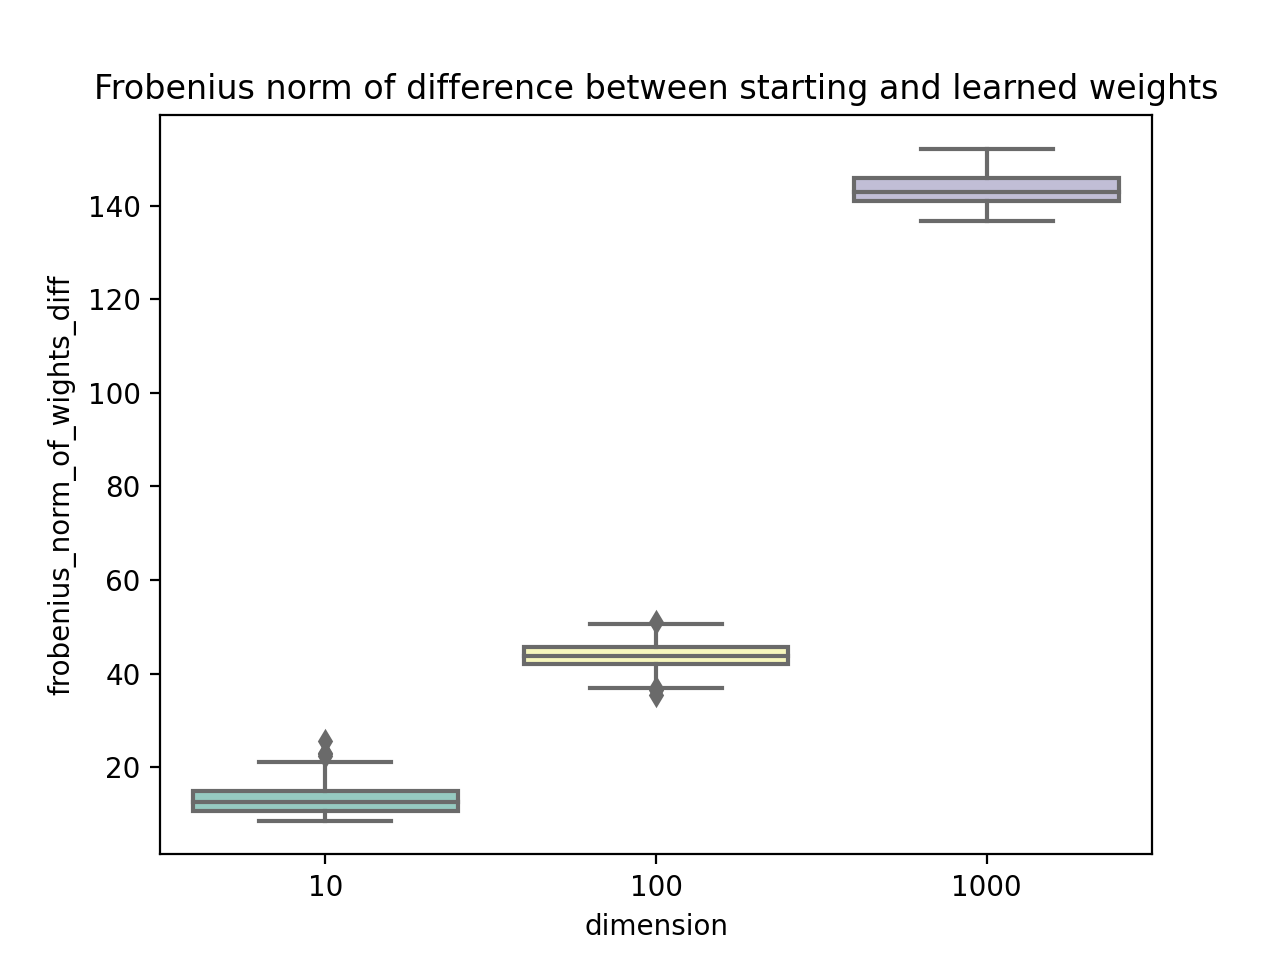

In [42]:
ax = sns.boxplot(x="dimension", y="frobenius_norm_of_wights_diff", data=df, palette="Set3")
ax.set_title('Frobenius norm of difference between starting and learned weights')

figure=ax.get_figure()
figure.savefig('../thesis/graphics/frobenius_norm_of_difference_between_starting_and_learned_weights_zeta_0_3.png')

In [39]:
#save data to file

cur_dir=pathlib.Path().resolve()
par_dir=cur_dir.parent

sim_dir=par_dir / 'thesis' / 'sim_data'

if not sim_dir.exists():
    sim_dir.mkdir(parents=True, exist_ok=True)

df.to_csv('../thesis/sim_data/frobenius_norm_of_difference_between_starting_and_nearned_weights.csv')

In [42]:
weight_diff_frob_norm_min, weight_diff_frob_norm_max=np.amin(err_vals, axis=1), np.amax(err_vals, axis=1)
weight_diff_frob_norm_mean=np.mean(err_vals, axis=1)

In [44]:
print(weight_diff_frob_norm_min)
print(weight_diff_frob_norm_max)
print(weight_diff_frob_norm_mean)

[6.611249  6.916219  7.0350823 7.0479436]
[7.472321  7.1976295 7.1218486 7.1039443]
[7.0702724 7.0789757 7.074441  7.0709925]


<IPython.core.display.Javascript object>


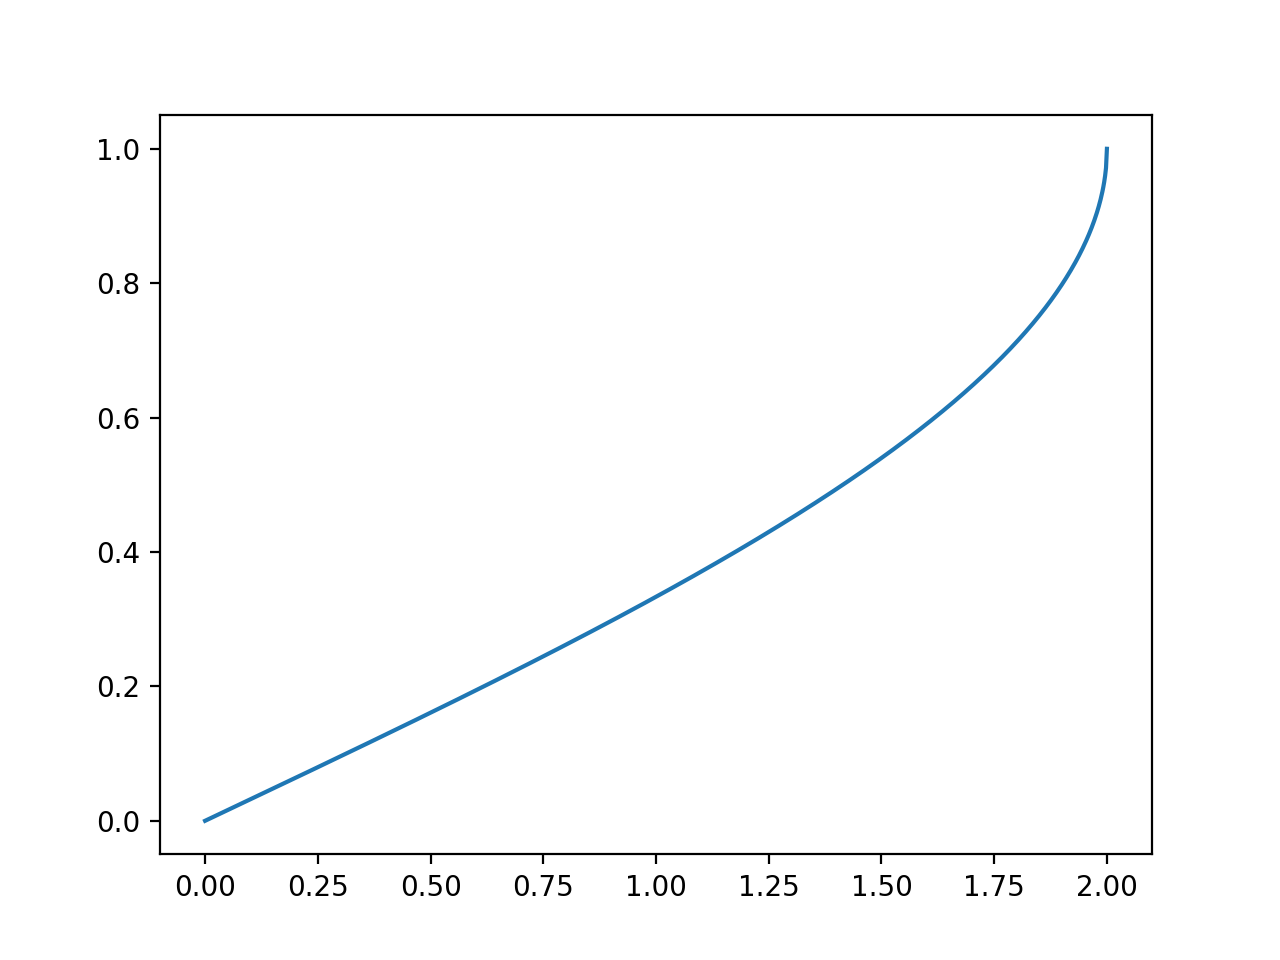

In [12]:
x=np.linspace(0,2,1000)

def f(x):
    t1=1-0.5*x**2
    t2=np.arcsin(t1)/np.pi
    t3=0.5-t2
    
    return t3

plt.plot(x, f(x))
plt.savefig('./aa.png')

In [ ]:
good_arrs=[[8*j+i for i in range(8)] for j in range(4)]

def sample_for_belot():
    perm=np.random.permutation(32)
    for i in range(4):
        tmp=perm[i*8:(i+1)*8]
        srt=np.sort(tmp)
        srt_list=srt.tolist()
        for good_arr in good_arrs:
            if good_arr==srt_list:
                return True
            
    return False
    
n_iter=5000000000
belot_cnt=0
for _ in range(n_iter):
    if sample_for_belot():
        belot_cnt+=1
        
print(belot_cnt/n_iter)

In [62]:
num,den=1,1
for i in range(8):
    num*=(32-i)
    den*=(i+1)
    
print(den/4*num)

4274906388480000.0


5.6893939393939394


info  : grbgetkey version 9.1.2, build v9.1.2rc0
info  : Contacting Gurobi license server...
^C
